In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime
import contextily as cx

This notebook illustrates how to extract a list of SLC images for interferograms associated to fixed frame enumeration. Here "fixed frames" simply means that the frames were generated based on the ESA burst map and they *do not change in time*. They consist of 10 contiguous bursts and overlap with adjacent frames with 2 bursts. Only frames that intersect the Natural Earth land geometry are kept. More details can be found at this [repo](https://github.com/ACCESS-Cloud-Based-InSAR/s1-frame-generation) in regards to how the frames were genreated. 

The challenge with enumarating SLC imagery for interferograms using the ESA imagery (as it is distributed) is that the frames are not constant in time therefore determining the inteferogram extents becomes an accounting nightmare quickly. This "fixed frame" approach circumvents this problem by collecting all imagery that covers a given fixed frame and submits that to processing (along with its region of interest).

There are some steps to each of this.

1. Get tracks (aka relative orbit numbers or path numbers) from AOI - this is manual/user selection
2. Get fixed frames from input AOI and selected track
3. Extract all viable imagery for a stack - the stack ensures each pass is completely covered
4. Enumerate SLC imagery for interferograms

# Get track number(s) for inteferogram genration from AOI

Inteferograms require the same viewing geometry so really only one track is acceptable. We only accept 1 track number except if we are at the equator and the track number gets incremented (for ESA accounting purposes), therefore a frame has two (sequential) tracks that it tracks. Selecting an AOI over the central coast of CA.

In [3]:
aoi_geo = Point(-120, 35).buffer(1)

df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

In [4]:
frames_all = get_overlapping_s1_frames(aoi_geo)
df_frames_all = frames2gdf(frames_all)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,5285,west,35,35,"POLYGON ((-122.7393 33.01088, -122.70519 32.86..."
1,5286,west,35,35,"POLYGON ((-123.00511 34.17223, -122.97077 34.0..."
2,5287,west,35,35,"POLYGON ((-123.28214 35.34912, -123.24386 35.1..."
3,6452,west,42,42,"POLYGON ((-122.94671 35.5999, -122.952 35.5736..."
4,6453,west,42,42,"POLYGON ((-123.1784 34.43885, -123.18387 34.41..."


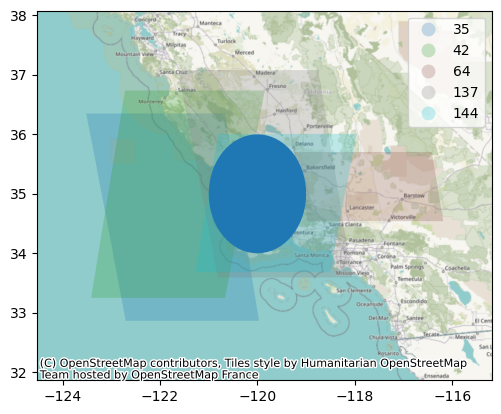

In [5]:
fig, ax = plt.subplots()
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
df_aoi.plot(ax=ax)
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)
cx.add_basemap(ax, crs=df_frames_by_track.crs)

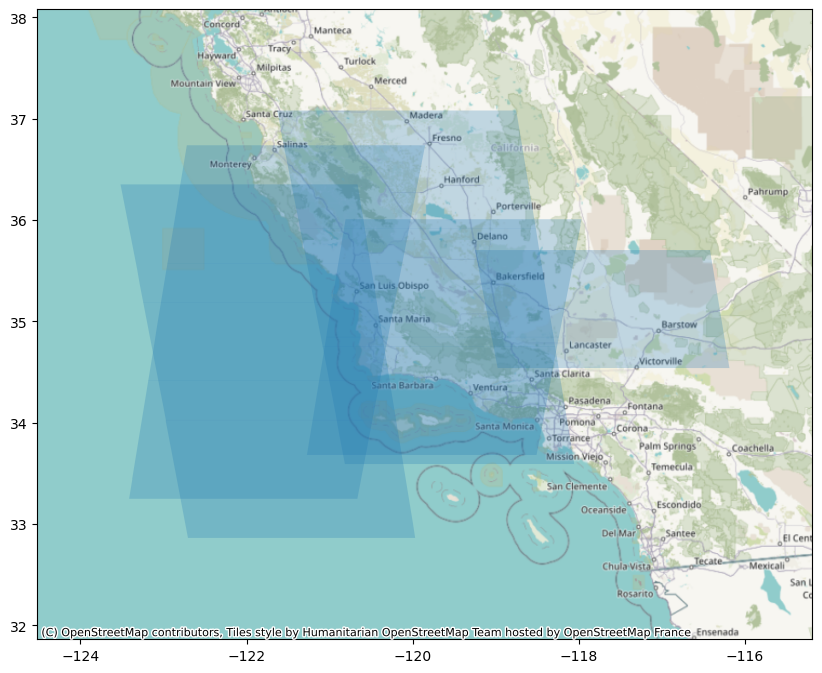

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
df_frames_all.plot(ax=ax, 
                        #column='track_numbers', 
                        alpha=.25, 
                        legend=True)
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)
cx.add_basemap(ax, crs=df_frames_by_track.crs)

# Get Frames from AOI and selected track

We *manually* select a track - could skip right to this point if we knew the AOI and track had overlap.

In [7]:
track_numbers = [144]
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=track_numbers)
frames

[S1Frame(frame_id=22439, hemisphere='west', track_numbers=[np.int32(144)], frame_geometry=<POLYGON ((-121.034 34.871, -121.04 34.844, -118.239 34.844, -117.977 35.95,...>, footprint_geometry=<POLYGON ((-120.204 34.589, -120.191 34.649, -119.745 34.586, -119.244 34.51...>),
 S1Frame(frame_id=22440, hemisphere='west', track_numbers=[np.int32(144)], frame_geometry=<POLYGON ((-121.267 33.71, -121.272 33.682, -118.507 33.682, -118.327 34.456...>, footprint_geometry=<POLYGON ((-119.501 33.352, -119.454 33.565, -118.565 33.431, -118.326 34.45...>)]

In [8]:
from s1_frame_enumerator.s1_frames import get_global_gunw_footprints

df_gunw = get_global_gunw_footprints()

<Axes: >

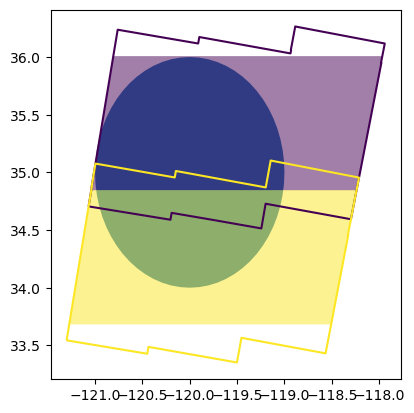

In [9]:
fig, ax = plt.subplots()

df_aoi.plot(ax=ax)
df_overlapping_frames = frames2gdf(frames)
df_overlapping_frames.plot(column='frame_id', alpha=.5, ax=ax)

df_footprints_gunw = df_gunw[df_gunw.frame_id.isin(df_overlapping_frames.frame_id.tolist())].reset_index(drop=True)
df_footprints_gunw.geometry = df_footprints_gunw.geometry.boundary
df_footprints_gunw.plot(column='frame_id', alpha=1, ax=ax)

# Get Stack from Frames

Here a stack is a list of images with metadata and extents. The stack is constructed and formatted rather carefully with the following properities:

1. Per frame coverage $\geq .25$% as it pertains to each frame's footprint (bursts that intersect the actual frame)
2. Contiguous coverage through a pass (determined as Polygon object) and
3. Per pass coverage of $\geq .80$% as determined by all the frame geometries aggregated together

There are two competing goals with any enumeration:

1. Spatial coverage: space covered by all dates in the time series stack
2. Temporal coverage: number of dates in stack 

Sacrificing spatial coverage in a given pass likely increases the overall temporal coverage and vice versa. There are some parameters worth exploring in the `get_s1_stack` that control the first item (i.e. spatial coverage) as it relates to per frame and per pass coverage. Decreasing these requirements will allow more dates to be included in the stack.

In [10]:
df_stack = get_s1_stack(frames)
df_stack.head()

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 7 simplified to 6 with proximity threshold of 0.0004'"]


,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,flight_direction,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SSV_20150519T135922_20150519T1359...,2015-05-19 13:59:22+00:00,2015-05-19 13:59:49+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV,5991,IW,2.474112,DESCENDING,9,2015-05-19 00:00:00+00:00,"POLYGON ((-118.03455 35.87319, -117.64374 37.4..."
1,S1A_IW_SLC__1SSV_20150519T135947_20150519T1400...,2015-05-19 13:59:47+00:00,2015-05-19 14:00:14+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV,5991,IW,2.482766,DESCENDING,9,2015-05-19 00:00:00+00:00,"POLYGON ((-118.37766 34.31689, -117.98006 35.9..."
2,S1A_IW_SLC__1SSV_20150519T140012_20150519T1400...,2015-05-19 14:00:12+00:00,2015-05-19 14:00:39+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV,5991,IW,2.279615,DESCENDING,9,2015-05-19 00:00:00+00:00,"POLYGON ((-118.71146 32.81956, -118.33259 34.4..."
3,S1A_IW_SLC__1SDV_20150531T135954_20150531T1400...,2015-05-31 13:59:54+00:00,2015-05-31 14:00:24+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV+VH,6166,IW,4.794067,DESCENDING,10,2015-05-31 00:00:00+00:00,"POLYGON ((-118.49665 33.81844, -118.07448 35.6..."
4,S1A_IW_SLC__1SDV_20150531T140022_20150531T1400...,2015-05-31 14:00:22+00:00,2015-05-31 14:00:49+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV+VH,6166,IW,3.826229,DESCENDING,10,2015-05-31 00:00:00+00:00,"POLYGON ((-118.83208 32.27101, -118.44412 33.9..."


In [11]:
df_stack.shape

(1137, 13)

# Generate Pairs

Now we generate the frames - most important elements of returned data is the SLC Ids of reference and secondary scenes.

In [12]:
min_temporal_baseline = 30
neighbors = 3

data = enumerate_gunw_time_series(df_stack, 
                                  min_temporal_baseline_days=min_temporal_baseline,
                                  n_secondary_scenes_per_ref=neighbors,
                                  frames=frames
                                  )

Date Pairs: 100%|█| 1140/1140 [00:23<00:00, 48.7


In [13]:
data[0]

{'reference': ['S1A_IW_SLC__1SDV_20250923T140014_20250923T140041_061116_079E46_8DCC',
  'S1A_IW_SLC__1SDV_20250923T140039_20250923T140106_061116_079E46_087C'],
 'secondary': ['S1C_IW_SLC__1SDV_20250824T135915_20250824T135941_003815_0079CA_4CE9',
  'S1C_IW_SLC__1SDV_20250824T135939_20250824T140014_003815_0079CA_62E9'],
 'reference_date': Timestamp('2025-09-23 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2025-08-24 00:00:00+0000', tz='UTC'),
 'frame_id': 22439,
 'geometry': <POLYGON ((-118.197 35.059, -118.194 35.058, -118.244 34.844, -121.04 34.844...>}

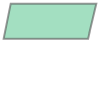

In [14]:
data[0]['geometry']

## Serialize

In [15]:
def update_item(item: dict):
    new_item = item.copy()
    new_item['bbox'] = list(item['geometry'].bounds)
    new_item.pop('geometry')
    return new_item

data_ifg = list(map(update_item, data))
data_ifg[0]

{'reference': ['S1A_IW_SLC__1SDV_20250923T140014_20250923T140041_061116_079E46_8DCC',
  'S1A_IW_SLC__1SDV_20250923T140039_20250923T140106_061116_079E46_087C'],
 'secondary': ['S1C_IW_SLC__1SDV_20250824T135915_20250824T135941_003815_0079CA_4CE9',
  'S1C_IW_SLC__1SDV_20250824T135939_20250824T140014_003815_0079CA_62E9'],
 'reference_date': Timestamp('2025-09-23 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2025-08-24 00:00:00+0000', tz='UTC'),
 'frame_id': 22439,
 'bbox': [-121.03970777704313,
  34.844158664445,
  -117.97137254266207,
  36.0077557975453]}

In [16]:
AOI_TOKEN = 'California'
TRACK_TOKENS = ','.join(list(map(str, track_numbers)))

class ifgEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, pd.Timestamp):
            return str(obj)

json.dump(data_ifg, 
          open(f'ifg_pair_{AOI_TOKEN}_{TRACK_TOKENS}.json', 'w'),
          indent=2,
          cls=ifgEncoder
         )

# Visualization (optional)


We are going to visualize the time series and individual frame coverage below. 

## Dates in Time-Series

In [17]:
x = json.dumps(data_ifg[:2], 
          indent=2,
          cls=ifgEncoder
         )

In [18]:
from s1_frame_enumerator import enumerate_dates
import networkx as nx

In [19]:
unique_dates = df_stack.repeat_pass_timestamp.unique()
date_pairs = enumerate_dates(unique_dates, min_temporal_baseline)
date_pairs[:3]

[(Timestamp('2025-09-23 00:00:00+0000', tz='UTC'),
  Timestamp('2025-08-24 00:00:00+0000', tz='UTC')),
 (Timestamp('2025-09-23 00:00:00+0000', tz='UTC'),
  Timestamp('2025-08-18 00:00:00+0000', tz='UTC')),
 (Timestamp('2025-09-23 00:00:00+0000', tz='UTC'),
  Timestamp('2025-08-12 00:00:00+0000', tz='UTC'))]

In [20]:
# Get unique dates
unique_dates = sorted(list(set(unique_dates)))

# initiate and plot date notes
date2node = {date: k for (k, date) in enumerate(unique_dates)}
node2date = {k: date for (date, k) in date2node.items()}

G = nx.DiGraph()

edges = [(date2node[ref_date], date2node[sec_date]) 
         for (ref_date, sec_date) in date_pairs]
G.add_edges_from(edges)

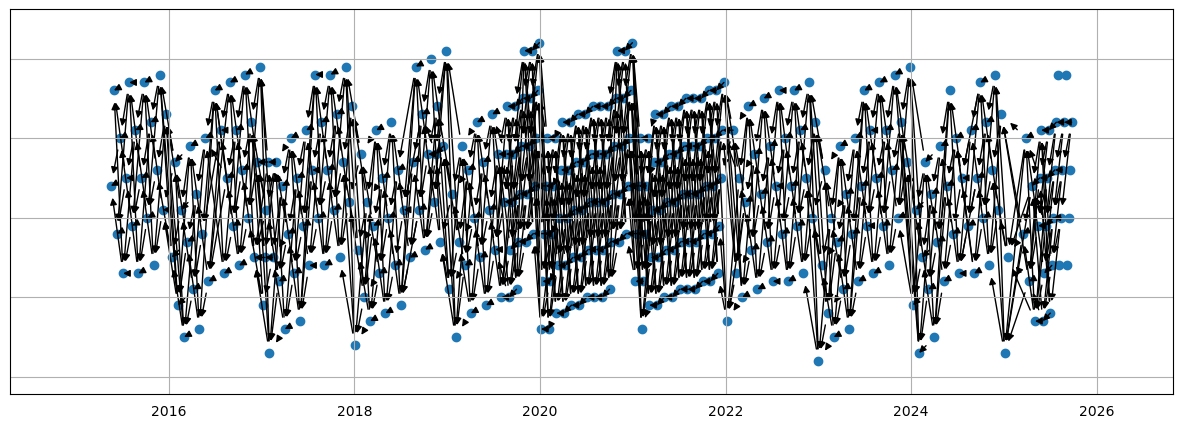

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))

increment = [date.month + date.day for date in unique_dates]

# source: https://stackoverflow.com/a/27852570
scat = ax.scatter(unique_dates, increment)
position = scat.get_offsets().data

pos = {date2node[date]: position[k] for (k, date) in enumerate(unique_dates)}
nx.draw_networkx_edges(G, pos=pos, ax=ax)
ax.grid('on')
ax.tick_params(axis='x',
               which='major',
               labelbottom=True,
               labelleft=True)
ymin, ymax = ax.get_ylim()

# Image Coverage

In [22]:
K = 0#100
data[K:K+1]

[{'reference': ['S1A_IW_SLC__1SDV_20250923T140014_20250923T140041_061116_079E46_8DCC',
   'S1A_IW_SLC__1SDV_20250923T140039_20250923T140106_061116_079E46_087C'],
  'secondary': ['S1C_IW_SLC__1SDV_20250824T135915_20250824T135941_003815_0079CA_4CE9',
   'S1C_IW_SLC__1SDV_20250824T135939_20250824T140014_003815_0079CA_62E9'],
  'reference_date': Timestamp('2025-09-23 00:00:00+0000', tz='UTC'),
  'secondary_date': Timestamp('2025-08-24 00:00:00+0000', tz='UTC'),
  'frame_id': 22439,
  'geometry': <POLYGON ((-118.197 35.059, -118.194 35.058, -118.244 34.844, -121.04 34.844...>}]

In [23]:
df_frame = gpd.GeoDataFrame(data[K:K+1], 
                            geometry=[data[K]['geometry']],
                            crs=CRS.from_epsg(4326))

df_ref = df_stack[df_stack.slc_id.isin(data[K]['reference'])].reset_index(drop=True)
df_sec = df_stack[df_stack.slc_id.isin(data[K]['secondary'])].reset_index(drop=True)

Text(0.5, 1.0, 'Secondary SLCs (blue), frame (yellow), \n and GUNW extent (black)')

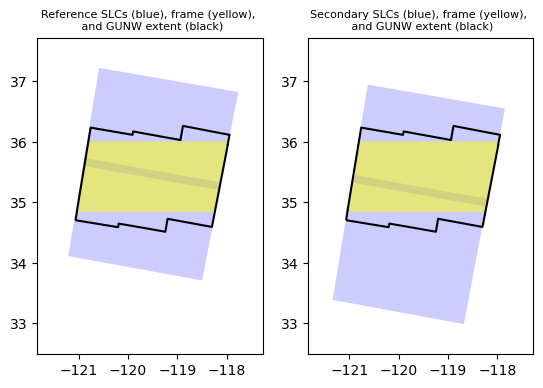

In [24]:
fig, ax = plt.subplots(1, 2)

df_footprints_gunw = df_gunw[df_gunw.frame_id.isin(df_frame.frame_id.tolist())]

for k in range(2):
    df_footprints_gunw.boundary.plot(ax=ax[k], color='black')
    
df_ref.plot(ax=ax[0], alpha=.2, color='blue')
df_frame.plot(ax=ax[0], alpha=.5, color='yellow')

df_sec.iloc[:4].plot(ax=ax[1], alpha=.2, color='blue')
df_frame.plot(ax=ax[1], alpha=.5, color='yellow')

xmin, ymin, xmax, ymax = pd.concat([df_ref, df_sec], axis=0).total_bounds

for k in range(2):
    ax[k].set_ylim(ymin - .5, ymax + .5)
    ax[k].set_xlim(xmin - .5, xmax + .5)

    
ax[0].set_title('Reference SLCs (blue), frame (yellow), \n and GUNW extent (black)', fontsize=8)
ax[1].set_title('Secondary SLCs (blue), frame (yellow), \n and GUNW extent (black)', fontsize=8)
